In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geodesic_toolbox import *
from statsmodels.graphics.tsaplots import plot_acf

In [5]:
def plot_auto_corr(samples, lags, title=None):
    fig, ax = plt.subplots(figsize=(12, 5))
    for i in range(samples.shape[2]):
        plot_acf(
            samples[0, :, i].cpu().numpy(),
            ax=ax,
            alpha=None,
            lags=lags,
            label=f"Dimension {i}",
        )
    ax.legend()
    ax.set_title(title or "Autocorrelation of Samples")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    plt.show()

In [6]:
# Generate data as an annulus
n = 1000
theta = torch.rand(n) * 2 * np.pi
r = torch.sqrt(torch.rand(n) * 0.5 + 0.5)
x = r * torch.cos(theta)
y = r * torch.sin(theta)
X = torch.stack([x, y], dim=1)

In [7]:
cometric = CentroidsCometric(
    centroids=X,
    cometric_centroids=IdentityCoMetric()(X),
    temperature_scale=0.1,
    K=-1,
)

bounds = get_bounds(X, margin=0.1)
print(cometric)
mf = get_mf_image(cometric, embeddings=X, bounds=bounds, resolution=100)

CentroidsCometric(K=1000, temperature=0.008, temp_scale=0.10000000149011612 reg_coef=0.001, metric_weight=True, is_diag=True)


Computing magnification factor: 100%|██████████| 20/20 [00:00<00:00, 269.52batch/s]


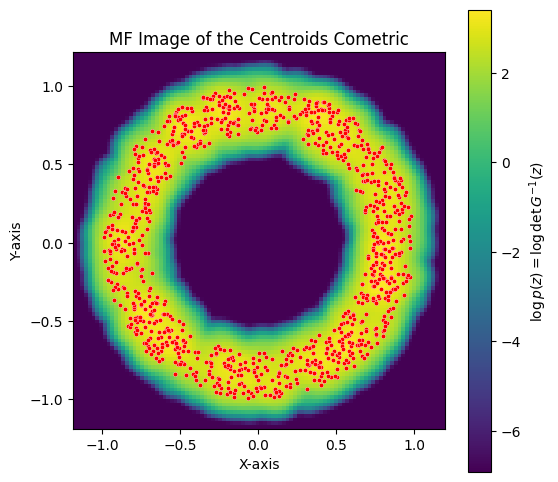

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
mf_img = ax.imshow((1 / mf).log(), extent=bounds, origin="lower", cmap="viridis")
sns.scatterplot(x=X[:, 0], y=X[:, 1], s=10, color="red", ax=ax)
ax.set_title("MF Image of the Centroids Cometric")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_xlim(bounds[0], bounds[1])
ax.set_ylim(bounds[2], bounds[3])
plt.colorbar(mf_img, ax=ax, label=r"""$\log p(z) = \log\det G^{-1}(z)$""")
plt.show()

In [9]:
sampler = ImplicitRHMCSampler(
    cometric=cometric,
    l=3,
    N_fx=5,
    gamma=0.01,
    N_run=1000,
    skip_acceptance=False,
)

p0 = X[torch.randint(0, X.shape[0], (1,))]
samples, acc_rate = sampler.sample(p0, progress=True, return_acceptance=True, return_traj=True)
print(f"Acceptance Rate: {acc_rate:.2f}")

Sampling: 100%|██████████| 1000/1000 [02:23<00:00,  6.96steps/s, acceptance_rate=0.132]

Acceptance Rate: 0.13


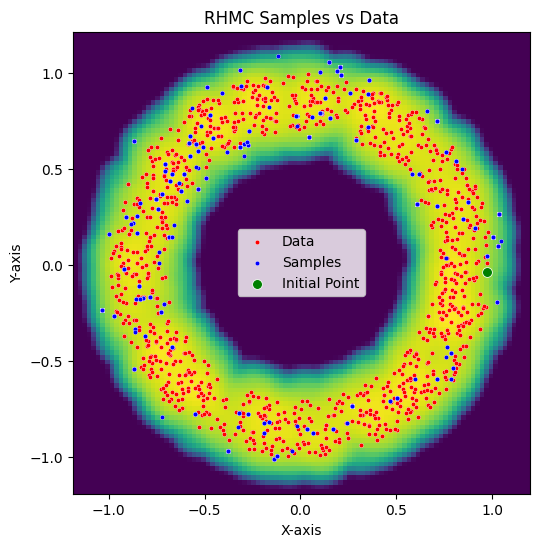

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow((1 / mf).log(), extent=bounds, origin="lower", cmap="viridis")
sns.scatterplot(x=X[:, 0], y=X[:, 1], s=10, color="red", label="Data", ax=ax)
sns.scatterplot(
    x=samples[0, :, 0], y=samples[0, :, 1], s=10, color="blue", label="Samples", ax=ax
)
# sns.lineplot(
#     x=samples[0, :, 0], y=samples[0, :, 1], color="blue", alpha=0.5, label="Trajectory", ax=ax
# )
sns.scatterplot(x=p0[:, 0], y=p0[:, 1], s=50, color="green", label="Initial Point", ax=ax)
ax.set_title("RHMC Samples vs Data")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.legend()
plt.show()

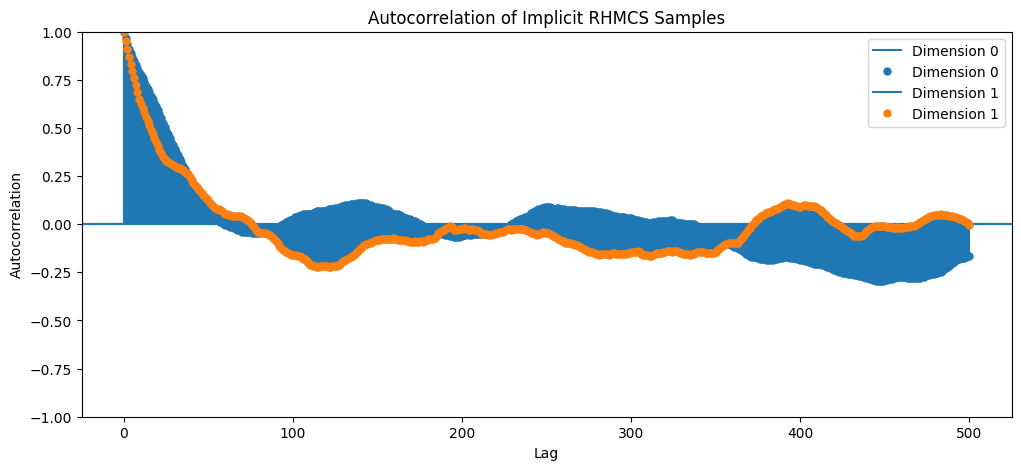

In [11]:
plot_auto_corr(samples, sampler.N_run // 2, title="Autocorrelation of Implicit RHMCS Samples")

In [12]:
explicit_sampler = ExplicitRHMCSampler(
    cometric=cometric,
    l=2,
    gamma=0.01,
    omega=10.0,
    N_run=1000,
)

samples_explicit, acc_rate_explicit = explicit_sampler.sample(
    p0, progress=True, return_acceptance=True, return_traj=True
)
print(f"Explicit RHMCS Acceptance Rate: {acc_rate_explicit:.2f}")

Sampling: 100%|██████████| 1000/1000 [00:48<00:00, 20.44steps/s, acceptance_rate=0.574]

Explicit RHMCS Acceptance Rate: 0.57


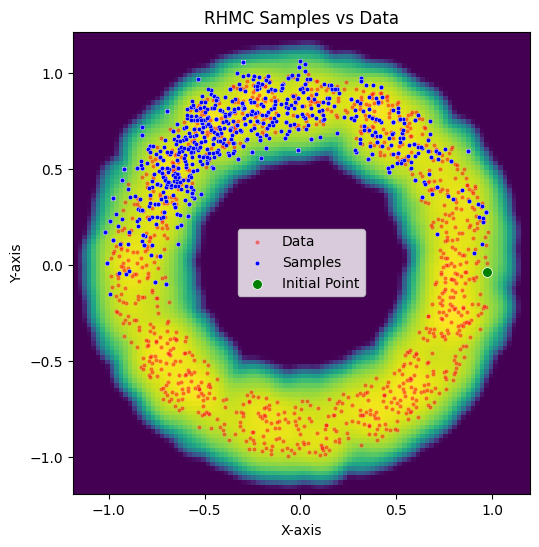

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow((1 / mf).log(), extent=bounds, origin="lower", cmap="viridis")
sns.scatterplot(x=X[:, 0], y=X[:, 1], s=10, color="red", label="Data", ax=ax, alpha=0.5)
sns.scatterplot(
    x=samples_explicit[0, :, 0],
    y=samples_explicit[0, :, 1],
    s=10,
    color="blue",
    label="Samples",
    ax=ax,
)
# sns.lineplot(
#     x=samples_explicit[0, :, 0],
#     y=samples_explicit[0, :, 1],
#     color="blue",
#     label="Explicit RHMCS Trajectory",
#     ax=ax,
# )
sns.scatterplot(x=p0[:, 0], y=p0[:, 1], s=50, color="green", label="Initial Point", ax=ax)
ax.set_title("RHMC Samples vs Data")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.legend()
plt.show()

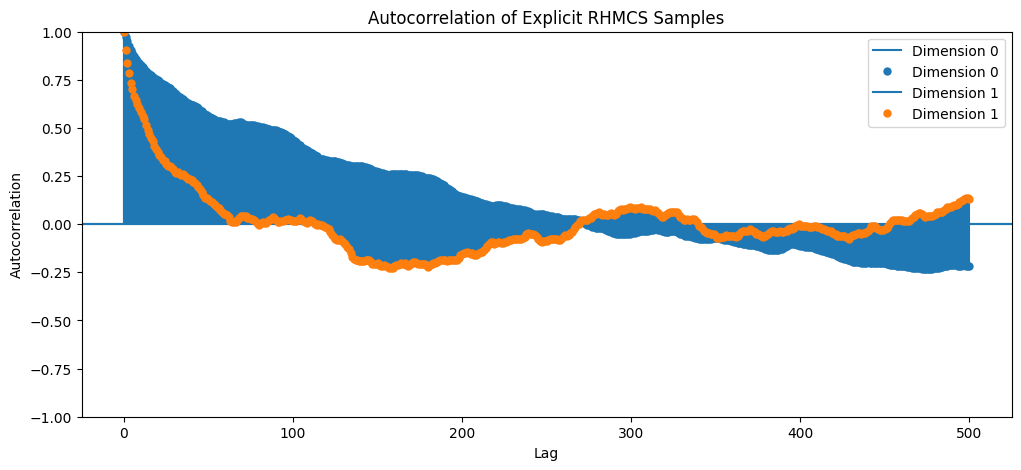

In [14]:
plot_auto_corr(
    samples_explicit,
    explicit_sampler.N_run // 2,
    title="Autocorrelation of Explicit RHMCS Samples",
)